# Arima Model


Data Preparation 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
import os
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

In [2]:
pd.set_option('display.max_columns', None)


In [3]:
df = pd.read_csv("US_Regional_Sales_Data.csv")

In [4]:
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,"1,001.18","1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,"3,348.66","3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,"1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,"1,464.69","2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,"1,476.14","1,822.40"


In [5]:
df = df.drop(['WarehouseCode','ProcuredDate','_SalesTeamID','_CustomerID','_StoreID','DeliveryDate','ShipDate','Sales Channel','Unit Cost','Discount Applied','_ProductID','OrderNumber'],axis=1)

In [6]:
df.head()

,OrderDate,CurrencyCode,Order Quantity,Unit Price
0,31/5/18,USD,5,"1,963.10"
1,31/5/18,USD,3,"3,939.60"
2,31/5/18,USD,1,"1,775.50"
3,31/5/18,USD,8,"2,324.90"
4,31/5/18,USD,8,"1,822.40"


In [7]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])  # Convert 'OrderDate' to datetime if not already

df['Unit Price'] = pd.to_numeric(df['Unit Price'].str.replace(',', ''), errors='coerce')


In [8]:
df = df.groupby('OrderDate').agg({
    'CurrencyCode': 'first',
    'Order Quantity': 'sum',
    'Unit Price': 'sum'
}).reset_index()
df['OrderDate'] = df['OrderDate'].dt.strftime('%d/%m/%y')


In [9]:
df

,OrderDate,CurrencyCode,Order Quantity,Unit Price
0,06/01/18,USD,62,31845.1
1,07/01/18,USD,27,14974.5
2,08/01/18,USD,42,15952.7
3,09/01/18,USD,36,13949.4
4,10/01/18,USD,25,14907.5
...,...,...,...,...
940,26/12/20,USD,41,16341.3
941,27/12/20,USD,48,25547.1
942,28/12/20,USD,56,46183.1
943,29/12/20,USD,37,18632.7


In [12]:
df.describe()

,Order Quantity,Unit Price,Total Sales
count,945.000000,945.000000,9.450000e+02
mean,38.266667,19318.234074,8.265076e+05
std,14.793666,8220.242354,5.980405e+05
min,2.000000,1031.800000,2.224400e+03
25%,28.000000,13111.900000,3.753876e+05
50%,38.000000,18786.800000,6.951116e+05
75%,48.000000,24649.300000,1.117580e+06
max,98.000000,48910.000000,3.699660e+06


In [10]:
df.dtypes


OrderDate          object
CurrencyCode       object
Order Quantity      int64
Unit Price        float64
dtype: object

In [11]:
df['Total Sales'] = df['Unit Price'] * df['Order Quantity']


In [12]:
df.isna().sum()

OrderDate         0
CurrencyCode      0
Order Quantity    0
Unit Price        0
Total Sales       0
dtype: int64

C:\Users\AMAN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


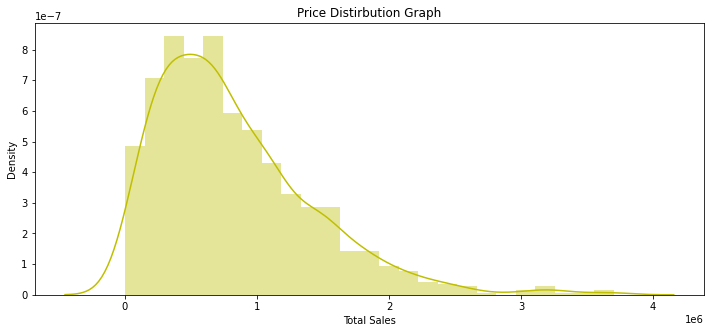

In [13]:
df['Total Sales'] = df['Total Sales'].astype(float)
plt.figure(figsize=(12,5))
plt.title("Price Distirbution Graph")
ax = sns.distplot(df["Total Sales"], color = 'y')

In [14]:
def ad_test(dataset):
    
    dftest = adfuller(dataset, autolag = 'AIC')
    
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)
         
         
ad_test(df['Total Sales'])

1. ADF :  -31.43899449117808
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 944
5. Critical Values :
	 1% :  -3.4372961556318304
	 5% :  -2.864606557310281
	 10% :  -2.568402813173298


In [15]:
stepwise_fit = auto_arima(df['Total Sales'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27830.702, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=27824.465, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27825.989, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27825.970, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28832.526, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27827.982, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.031 seconds


In [16]:
X = df['Total Sales']
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [17]:
seasonal_period = 4  # For weekly data, for example

# Calculate the moving average
moving_average = df['Total Sales'].rolling(window=seasonal_period, min_periods=1).mean()

# Calculate the seasonal factor
seasonal_factor = df['Total Sales'] - moving_average

In [18]:
seasonal_factor

0      0.000000e+00
1     -7.850424e+05
2     -3.462270e+05
3     -3.855465e+05
4     -1.146102e+05
           ...     
940    1.561267e+04
941    3.991625e+05
942    1.383996e+06
943   -6.035695e+05
944   -9.277473e+05
Name: Total Sales, Length: 945, dtype: float64

In [19]:
window_size = 10  # Replace with the appropriate window size

# Calculate the moving average
df['Moving Average'] = df['Order Quantity'].rolling(window=window_size).mean()

# Calculate the seasonal factor
df['Seasonal Factor'] = df['Order Quantity'] - df['Moving Average']

# Drop rows with NaN values in the 'Seasonal Factor' column
df.dropna(subset=['Seasonal Factor'], inplace=True)

In [20]:
df

,OrderDate,CurrencyCode,Order Quantity,Unit Price,Total Sales,Moving Average,Seasonal Factor
9,08/02/18,USD,30,11577.6,347328.0,37.0,-7.0
10,09/02/18,USD,45,13306.2,598779.0,35.3,9.7
11,10/02/18,USD,31,24099.9,747096.9,35.7,-4.7
12,11/02/18,USD,39,10418.5,406321.5,35.4,3.6
13,12/02/18,USD,35,13132.0,459620.0,35.3,-0.3
...,...,...,...,...,...,...,...
940,26/12/20,USD,41,16341.3,669993.3,42.4,-1.4
941,27/12/20,USD,48,25547.1,1226260.8,41.5,6.5
942,28/12/20,USD,56,46183.1,2586253.6,44.0,12.0
943,29/12/20,USD,37,18632.7,689409.9,45.5,-8.5


C:\Users\AMAN\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


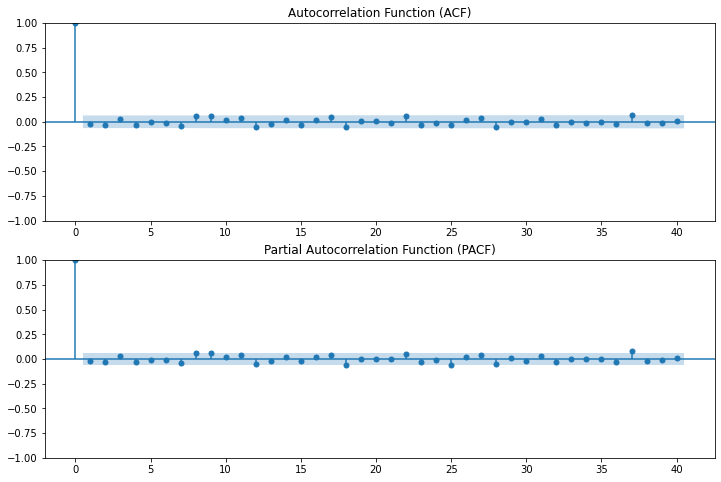

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(df['Total Sales'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['Total Sales'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

In [22]:
df.isna().sum()

OrderDate          0
CurrencyCode       0
Order Quantity     0
Unit Price         0
Total Sales        0
Moving Average     0
Seasonal Factor    0
dtype: int64

In [23]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%d/%m/%y')
df.set_index('OrderDate', inplace=True)


Model Training and Building

C:\Users\AMAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AMAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AMAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AMAN\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

RMSE: 316520.263168887
R2 Score: 0.6577904808910784


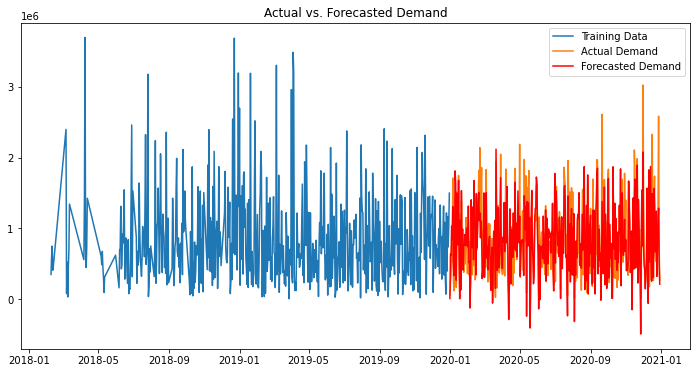

In [26]:
# Split the dataset into training and testing sets
train = df['2018-01-06':'2019-12-31']
test = df['2020-01-01':'2020-12-31']

# Define the order for the ARIMA model
p, d, q = 38, 0, 18


# Exogenous variable (external factor): 'Discount Applied'
exog_train = train[['Seasonal Factor']]
exog_test = test[['Seasonal Factor']]

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model with exogenous variables
model = ARIMA(train['Total Sales'], order=(p, d, q), exog=exog_train)
model_fit = model.fit()

# Make predictions for the test set
forecast = model_fit.get_forecast(steps=len(test), exog=exog_test)
forecast_mean = forecast.predicted_mean

# Calculate the Root Mean Squared Error (RMSE) as a measure of model accuracy
rmse_val = np.sqrt(mean_squared_error(test['Total Sales'], forecast_mean))
print(f"RMSE: {rmse_val}")
r2 = r2_score(test['Total Sales'], forecast_mean)
print(f"R2 Score: {r2}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total Sales'], label='Training Data')
plt.plot(test.index, test['Total Sales'], label='Actual Demand')
plt.plot(test.index, forecast_mean, label='Forecasted Demand', color='red')
plt.legend()
plt.title('Actual vs. Forecasted Demand')
plt.show()

In [27]:
# Reset the index for the test and forecast_mean DataFrames
test = test.reset_index()
forecast_mean = forecast_mean.reset_index()

# Create a DataFrame with the actual and predicted values
actual_vs_predicted = pd.DataFrame({'Actual': test['Total Sales'], 'Predicted': forecast_mean['predicted_mean']})

# Print the DataFrame
print(actual_vs_predicted)


        Actual     Predicted
0      56139.3  4.895007e+03
1     237876.8  6.319134e+05
2     360192.0  6.146680e+05
3     746085.2  1.031459e+06
4     521434.2  8.466766e+05
..         ...           ...
360   669993.3  7.732312e+05
361  1226260.8  1.074109e+06
362  2586253.6  1.283990e+06
363   689409.9  5.222886e+05
364   263645.0  2.092405e+05

[365 rows x 2 columns]
